In [1]:
import os
os.chdir('../..')


In [54]:
from classes.helpers import *
import numpy as np
import json
import pandas as pd
import scipy.stats as ss
from sklearn import linear_model
import ast
import scipy.stats as ss


import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

from scipy.optimize import minimize

# For the Python notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

data_folder = '../data/'

colors = {'H for (H-H)': '#8b0000',
          'H for (H-L)': '#c1253d',
          'H for (H-M)': '#e75c59',
          'M for (H-M)': '#fe9755',
          'M for (M-M)': '#ffd700',
          'M for (L-M)': '#9dcd75',
          'L for (L-M)': '#6cb482',
          'L for (H-L)': '#419a83',
          'L for (L-L)': '#008080',
          'ba': 'b',
          'rb': 'r'}

min_nbr_rats = 1

## Load Time Series DF with ranks

In [47]:
df = pd.read_csv(data_folder + 'tmp/time_series_{}_ranks_valid.csv'.format(min_nbr_rats), header=[0,1])

# Transform strings into arrays
for i in df.index:
    for key1 in ['ba', 'rb']:
        for key2 in ['dates', 'ratings', 'z_scores', 'ranks']:
            arr = ast.literal_eval(df.loc[i][key1][key2])
            df.set_value(i, (key1, key2), arr)

In [60]:
with open(data_folder + 'tmp/global_averages.json') as file:
    global_avg = json.load(file)

diffs = {'ba': [], 'rb': []}
for i in df.index:
    row = df.iloc[i]
    for key in ['rb', 'ba']:
        diffs[key].append(row[key]['z_scores'][0] - global_avg[key]['z_score'])
        
thresholds = {}

for key in ['ba', 'rb']:
    thresholds[key] = {}
    thresholds[key]['low'] = np.percentile(diffs[key], 15)
    thresholds[key]['high'] = np.percentile(diffs[key], 85)

## Classify ratings (check)

In [61]:
classes = {}

for i in df.index:    
    ba = diffs['ba'][i]
    rb = diffs['rb'][i]


    if ba > thresholds['ba']['high']:
        class_ = 'H'
    elif ba >= thresholds['ba']['low']:
        class_ = 'M'
    else:
        class_ = 'L'

    class_ += '-'

    if rb > thresholds['rb']['high']:
        class_ += 'H'
    elif rb >= thresholds['rb']['low']:
        class_ += 'M'
    else:
        class_ += 'L' 

    if class_ not in classes.keys():
        classes[class_] = 0

    classes[class_] += 1

In [62]:
classes

{'H-H': 1290,
 'H-L': 300,
 'H-M': 2499,
 'L-H': 234,
 'L-L': 1351,
 'L-M': 2529,
 'M-H': 2560,
 'M-L': 2451,
 'M-M': 14218}

## Histogram 1D

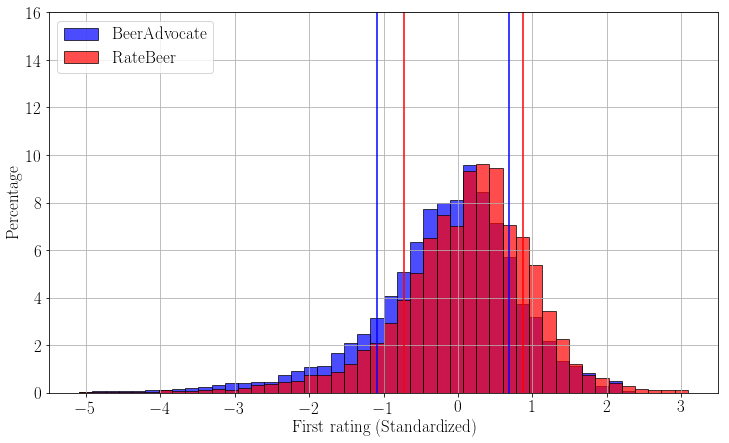

In [63]:
labels = {'ba': 'BeerAdvocate', 'rb': 'RateBeer'}

nbr_bins = 45

bin_edges = {'ba': None, 'rb': None}
hist = {'ba': None, 'rb': None}

for key in labels.keys():
    a, bin_edges[key] = np.histogram(diffs[key], range=(-5, 3), bins=nbr_bins)
    hist[key], a = np.histogram(diffs[key], range=(-5, 3), bins=nbr_bins+1)
    hist[key] = hist[key]/np.sum(hist[key])*100

plt.figure(figsize=(12,7))
plt.rc('font', family='serif')
plt.rc('font', size=17)

for key in hist.keys():
    width = bin_edges[key][1] - bin_edges[key][0]
    plt.bar(bin_edges[key], hist[key], width = width, facecolor=colors[key], edgecolor='k', alpha=0.7, label=labels[key])

plt.grid()
plt.legend(loc=2)
plt.ylim([0, 16])

for key in labels.keys():        
    plt.plot([thresholds[key]['low'], thresholds[key]['low']], [0, 16], colors[key])
    plt.plot([thresholds[key]['high'], thresholds[key]['high']], [0, 16], colors[key])

plt.ylabel('Percentage')
plt.xlabel('First rating (Standardized)')
#plt.savefig('../figures/blog/histograms_diff.png', bbox_inches='tight', transparent=True)

## Bootstrap

In [42]:
classes_to_study = ['H-H', 'L-L', 'M-M', 'L-M', 'H-L', 'H-M']

nbr_draws = 1000

ranks = {}

min_nbr_ratings = min_nbr_rats

# Go through all the classes
for cl in classes_to_study:
    
    if cl[0] != cl[-1]:
        # Take care of first class
        
        classes = [cl[0] + ' for (' + cl + ')', cl[-1] + ' for (' + cl + ')']
                
        subdf = df[(((df['ba']['class'] == cl[0]) & (df['rb']['class'] == cl[-1])) | 
                   ((df['ba']['class'] == cl[-1]) & (df['rb']['class'] == cl[0]))) &
                   (df['ba']['nbr_ratings'] >= min_nbr_ratings) & (df['rb']['nbr_ratings'] >= min_nbr_ratings)] 
        
        for class_ in classes:
            ranks[class_] = {'avg': [], 'low': [], 'high': []}
            
            letter = class_[0]
            
            ba = subdf[subdf['ba']['class'] == letter]['ba']
            rb = subdf[subdf['rb']['class'] == letter]['rb']
            
            nbr = min(len(ba), len(rb))
            
            # Go through all the ratings
            for i in range(min_nbr_ratings):
                
                ranks_ba = np.array([r[i] for r in ba['ranks']])
                ranks_rb = np.array([r[i] for r in rb['ranks']])
                
                tmp = []
                # Go through each draw
                for d in range(nbr_draws):
                    
                    # Get the indices
                    idx_ba = np.random.randint(0, len(ba), nbr)
                    idx_rb = np.random.randint(0, len(rb), nbr)
                    
                    ranks_tmp = ranks_ba[idx_ba]
                    ranks_tmp = np.append(ranks_tmp, ranks_rb[idx_rb])
                                        
                    tmp.append(np.mean(ranks_tmp))
                    
                avg = (np.mean(ranks_ba) + np.mean(ranks_rb))/2
                ranks[class_]['avg'].append(avg)
                ranks[class_]['low'].append(np.percentile(tmp, 2.5))
                ranks[class_]['high'].append(np.percentile(tmp, 97.5))            
        
    else:
        
        class_ = cl[0] + ' for (' + cl + ')'
        ranks[class_] = {'avg': [], 'low': [], 'high': []}
        
        subdf = df[(df['ba']['class'] == cl[0]) & (df['rb']['class'] == cl[0]) &
                   (df['ba']['nbr_ratings'] >= min_nbr_ratings) & (df['rb']['nbr_ratings'] >= min_nbr_ratings)]

        # Go through all the ratings
        for i in range(min_nbr_ratings):
             
            ranks_both = np.array([r[i] for r in subdf['ba']['ranks']])
            ranks_both = np.append(ranks_both, np.array([r[i] for r in subdf['rb']['ranks']]))

            tmp = []
            # Go through each draw
            for d in range(nbr_draws):
                
                indices = np.random.randint(0, len(ranks_both), len(ranks_both))
                
                ranks_tmp = ranks_both[indices]
                
                tmp.append(np.mean(ranks_tmp))
            
            ranks[class_]['avg'].append(np.mean(ranks_both))
            ranks[class_]['low'].append(np.percentile(tmp, 2.5))
            ranks[class_]['high'].append(np.percentile(tmp, 97.5))

## Plot Herding

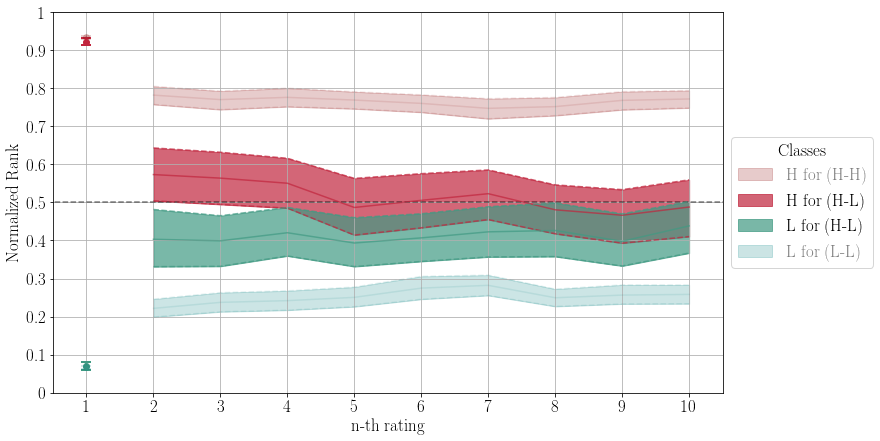

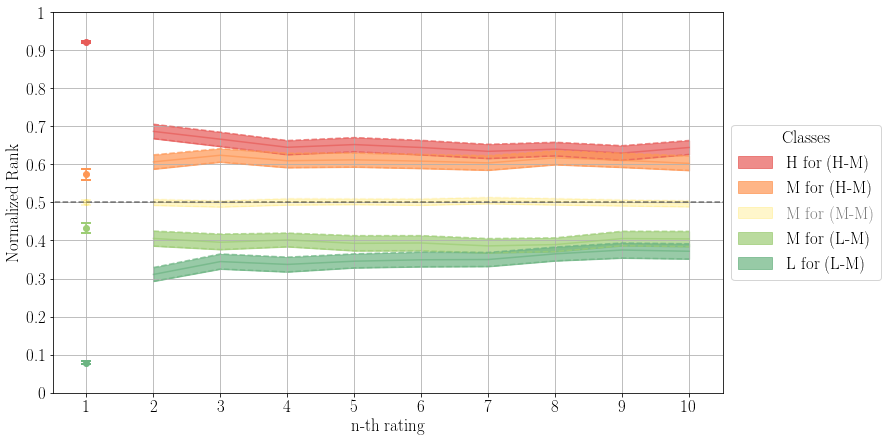

In [43]:
for type_ in ['extreme', 'medium']:

    plt.figure(figsize=(12, 7))
    plt.grid()

    plt.rc('font', family='serif')
    plt.rc('font', size=17)

    ax = plt.subplot(111)

    plt.plot([-2, min_nbr_ratings + 2], [0.5, 0.5], '--k', alpha=0.5)

    if type_ == 'extreme':
        classes_to_plot = ['H for (H-H)','H for (H-L)', 'L for (H-L)', 'L for (L-L)']

        vals = [0, 3]

    elif type_ == 'medium':  
        classes_to_plot = ['H for (H-M)', 'M for (H-M)', 'M for (M-M)', 'M for (L-M)', 'L for (L-M)']

        vals = [2]

    i = 0
    for class_ in classes_to_plot:

        ranks_tmp = ranks[class_]

        avg = np.array(ranks_tmp['avg'])
        high = np.array(ranks_tmp['high'])
        low = np.array(ranks_tmp['low'])

        if i in vals:
            alpha = 0.2
        else:
            alpha = 1

        plt.errorbar(1, avg[0], yerr=[[high[0]-avg[0]], [avg[0]-low[0]]],
                    fmt='o', capsize=5, capthick=2, c=colors[class_], alpha=alpha)

        avg = avg[1:]
        high = high[1:]
        low = low[1:]

        if i in vals:
            alpha = 0.1
        else:
            alpha = 0.7

        plt.plot(range(2, min_nbr_ratings + 1), avg, color=colors[class_], alpha=alpha)
        plt.plot(range(2, min_nbr_ratings + 1), high, '--', color=colors[class_], alpha=alpha)
        plt.plot(range(2, min_nbr_ratings + 1), low, '--', color=colors[class_], alpha=alpha)

        if i in vals:
            alpha = 0.2
        else:
            alpha = 0.7
        plt.fill_between(range(2, min_nbr_ratings + 1), low, high, color=colors[class_], alpha=alpha, label = class_) 

        i+=1

    l = plt.legend(title='Classes', loc='center left', bbox_to_anchor=(1, 0.5))
    if min_nbr_ratings <= 20:
        plt.xticks(list(range(1,min_nbr_ratings + 1)))
    elif min_nbr_ratings <= 50:
        plt.xticks(list(range(0, min_nbr_ratings + 1, 2)))
    else:
        plt.xticks(list(range(0, min_nbr_ratings + 1, 5)))

    i = 0
    for text in l.get_texts():
        if i in vals:
            text.set_color('gray')
        i+=1

    plt.ylim([0, 1])
    plt.xlim([0.5, min_nbr_ratings + 0.5])

    yticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

    plt.yticks(yticks, yticks)
    plt.xlabel('n-th rating')
    plt.ylabel('Normalized Rank')

    #plt.savefig('../figures/blog/herding_{}_{}.png'.format(type_, min_nbr_ratings), bbox_inches='tight', transparent=True)

## Herding with varying number of beers

In [67]:
classes_to_study = ['H-H', 'L-L', 'M-M', 'L-M', 'H-L', 'H-M']

nbr_draws = 1000

nbr_ratings = 10

ranks = {}

# Go through all the classes
for cl in classes_to_study:
    
    if cl[0] != cl[-1]:
        # Take care of first class
        
        classes = [cl[0] + ' for (' + cl + ')', cl[-1] + ' for (' + cl + ')']

        for class_ in classes:
            ranks[class_] = {'avg': [], 'low': [], 'high': []}
            
            letter = class_[0]
            
            # Go through all the ratings
            for i in range(nbr_ratings):
                                
                subdf = df[(((df['ba']['class'] == cl[0]) & (df['rb']['class'] == cl[-1])) | 
                           ((df['ba']['class'] == cl[-1]) & (df['rb']['class'] == cl[0]))) &
                           (df['ba']['nbr_ratings'] >= i+1) & (df['rb']['nbr_ratings'] >= i+1)] 
                
                ba = subdf[subdf['ba']['class'] == letter]['ba']
                rb = subdf[subdf['rb']['class'] == letter]['rb']

                nbr = min(len(ba), len(rb))
                
                ranks_ba = np.array([r[i] for r in ba['ranks']])
                ranks_rb = np.array([r[i] for r in rb['ranks']])
                
                tmp = []
                # Go through each draw
                for d in range(nbr_draws):
                    
                    # Get the indices
                    idx_ba = np.random.randint(0, len(ba), nbr)
                    idx_rb = np.random.randint(0, len(rb), nbr)
                    
                    ranks_tmp = ranks_ba[idx_ba]
                    ranks_tmp = np.append(ranks_tmp, ranks_rb[idx_rb])
                                        
                    tmp.append(np.mean(ranks_tmp))
                    
                avg = (np.mean(ranks_ba) + np.mean(ranks_rb))/2
                ranks[class_]['avg'].append(avg)
                ranks[class_]['low'].append(np.percentile(tmp, 2.5))
                ranks[class_]['high'].append(np.percentile(tmp, 97.5))            
        
    else:
        
        class_ = cl[0] + ' for (' + cl + ')'
        ranks[class_] = {'avg': [], 'low': [], 'high': []}
        
        # Go through all the ratings
        for i in range(nbr_ratings):
            
            subdf = df[(df['ba']['class'] == cl[0]) & (df['rb']['class'] == cl[0]) &
                       (df['ba']['nbr_ratings'] >= i+1) & (df['rb']['nbr_ratings'] >= i+1)]
             
            ranks_both = np.array([r[i] for r in subdf['ba']['ranks']])
            ranks_both = np.append(ranks_both, np.array([r[i] for r in subdf['rb']['ranks']]))

            tmp = []
            # Go through each draw
            for d in range(nbr_draws):
                
                indices = np.random.randint(0, len(ranks_both), len(ranks_both))
                
                ranks_tmp = ranks_both[indices]
                
                tmp.append(np.mean(ranks_tmp))
            
            ranks[class_]['avg'].append(np.mean(ranks_both))
            ranks[class_]['low'].append(np.percentile(tmp, 2.5))
            ranks[class_]['high'].append(np.percentile(tmp, 97.5))

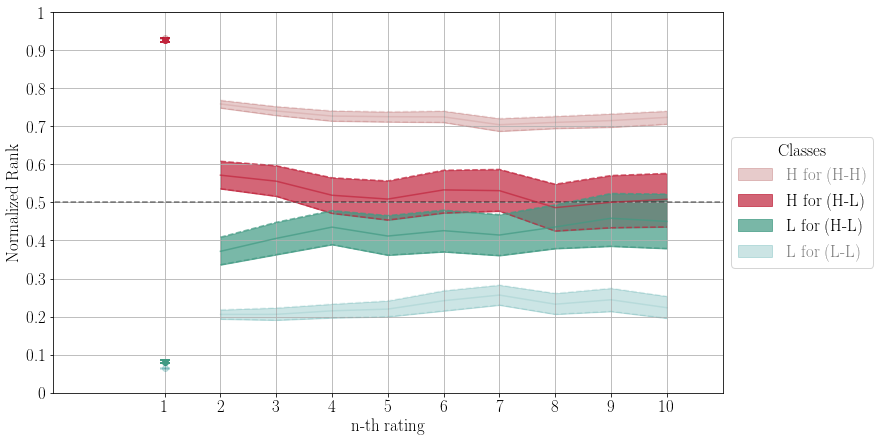

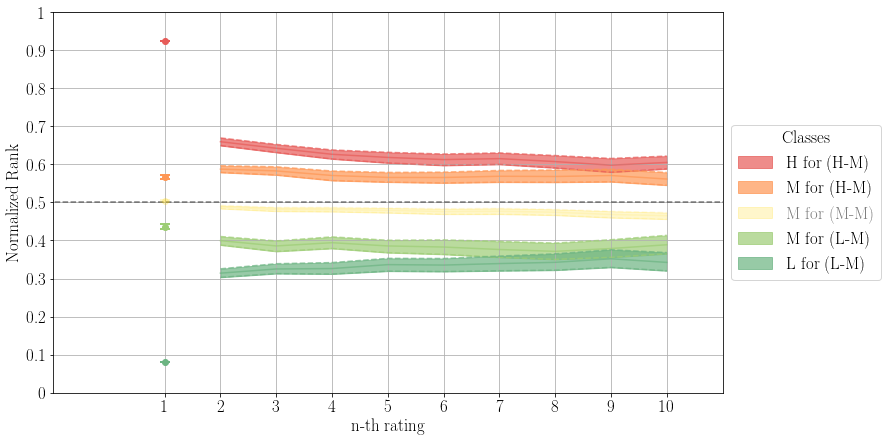

In [68]:
for type_ in ['extreme', 'medium']:

    plt.figure(figsize=(12, 7))
    plt.grid()

    plt.rc('font', family='serif')
    plt.rc('font', size=17)

    ax = plt.subplot(111)

    plt.plot([-2, nbr_ratings + 2], [0.5, 0.5], '--k', alpha=0.5)

    if type_ == 'extreme':
        classes_to_plot = ['H for (H-H)','H for (H-L)', 'L for (H-L)', 'L for (L-L)']

        vals = [0, 3]

    elif type_ == 'medium':  
        classes_to_plot = ['H for (H-M)', 'M for (H-M)', 'M for (M-M)', 'M for (L-M)', 'L for (L-M)']

        vals = [2]

    i = 0
    for class_ in classes_to_plot:

        ranks_tmp = ranks[class_]

        avg = np.array(ranks_tmp['avg'])
        high = np.array(ranks_tmp['high'])
        low = np.array(ranks_tmp['low'])

        if i in vals:
            alpha = 0.2
        else:
            alpha = 1

        plt.errorbar(1, avg[0], yerr=[[high[0]-avg[0]], [avg[0]-low[0]]],
                    fmt='o', capsize=5, capthick=2, c=colors[class_], alpha=alpha)

        avg = avg[1:]
        high = high[1:]
        low = low[1:]

        if i in vals:
            alpha = 0.1
        else:
            alpha = 0.7

        plt.plot(range(2, nbr_ratings + 1), avg, color=colors[class_], alpha=alpha)
        plt.plot(range(2, nbr_ratings + 1), high, '--', color=colors[class_], alpha=alpha)
        plt.plot(range(2, nbr_ratings + 1), low, '--', color=colors[class_], alpha=alpha)

        if i in vals:
            alpha = 0.2
        else:
            alpha = 0.7
        plt.fill_between(range(2, nbr_ratings + 1), low, high, color=colors[class_], alpha=alpha, label = class_) 

        i+=1

    l = plt.legend(title='Classes', loc='center left', bbox_to_anchor=(1, 0.5))
    if nbr_ratings <= 20:
        plt.xticks(list(range(1,nbr_ratings + 1)))
    elif nbr_ratings <= 50:
        plt.xticks(list(range(0, nbr_ratings + 1, 2)))
    else:
        plt.xticks(list(range(0, nbr_ratings + 1, 5)))

    i = 0
    for text in l.get_texts():
        if i in vals:
            text.set_color('gray')
        i+=1

    plt.ylim([0, 1])
    plt.xlim([-1, nbr_ratings + 1])

    yticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

    plt.yticks(yticks, yticks)
    plt.xlabel('n-th rating')
    plt.ylabel('Normalized Rank')

    #plt.savefig('../figures/blog/herding_{}_varying_{}.png'.format(type_, nbr_ratings), bbox_inches='tight', transparent=True)

## Long term average

In [17]:
classes_to_study = ['H-H', 'H-L', 'L-L', 'H-M', 'M-M', 'L-M']

nbr_draws = 1000

min_nbr_ratings = 20

classes_names = []
ranks_lta = {'avg': [], 'low': [], 'high': []}

# Go through all the classes
for cl in classes_to_study:
    
    if cl[0] != cl[-1]:
        # Take care of first class
        
        if cl == 'L-M':
            classes = [cl[-1] + ' for (' + cl + ')', cl[0] + ' for (' + cl + ')']
        else:
            classes = [cl[0] + ' for (' + cl + ')', cl[-1] + ' for (' + cl + ')']
        
        subdf = df[((df['ba']['class'] == cl[0]) & (df['rb']['class'] == cl[-1])) | 
                   ((df['ba']['class'] == cl[-1]) & (df['rb']['class'] == cl[0]))] 
        subdf = subdf[(subdf['ba']['nbr_ratings'] >= min_nbr_ratings) & (subdf['rb']['nbr_ratings'] >= min_nbr_ratings)]
        
        for class_ in classes:
            classes_names.append(class_)
            
            letter = class_[0]
            
            ba = subdf[subdf['ba']['class'] == letter]['ba']
            rb = subdf[subdf['rb']['class'] == letter]['rb']
                        
            nbr = min(len(ba), len(rb))
            
            ranks_ba = np.array(ba['rank_avg'])
            ranks_rb = np.array(rb['rank_avg'])
                
            tmp = []
            # Go through each draw
            for d in range(nbr_draws):

                # Get the indices
                idx_ba = np.random.randint(0, len(ba), nbr)
                idx_rb = np.random.randint(0, len(rb), nbr)

                ranks_tmp = ranks_ba[idx_ba]
                ranks_tmp = np.append(ranks_tmp, ranks_rb[idx_rb])

                tmp.append(np.mean(ranks_tmp))

            avg = (np.mean(ranks_ba) + np.mean(ranks_rb))/2
            ranks_lta['avg'].append(avg)
            ranks_lta['low'].append(np.percentile(tmp, 2.5))
            ranks_lta['high'].append(np.percentile(tmp, 97.5))            
        
    else:
        
        class_ = cl[0] + ' for (' + cl + ')'
        classes_names.append(class_)
        
        subdf = df[(df['ba']['class'] == cl[0]) & (df['rb']['class'] == cl[0])]
            
        subdf = subdf[(subdf['ba']['nbr_ratings'] >= min_nbr_ratings) & (subdf['rb']['nbr_ratings'] >= min_nbr_ratings)]
            
        ranks_both = np.array(subdf['ba']['rank_avg'])
        ranks_both = np.append(ranks_both, np.array(subdf['rb']['rank_avg']))

        tmp = []
        # Go through each draw
        for d in range(nbr_draws):

            indices = np.random.randint(0, len(ranks_both), len(ranks_both))

            ranks_tmp = ranks_both[indices]

            tmp.append(np.mean(ranks_tmp))

        ranks_lta['avg'].append(np.mean(ranks_both))
        ranks_lta['low'].append(np.percentile(tmp, 2.5))
        ranks_lta['high'].append(np.percentile(tmp, 97.5))  

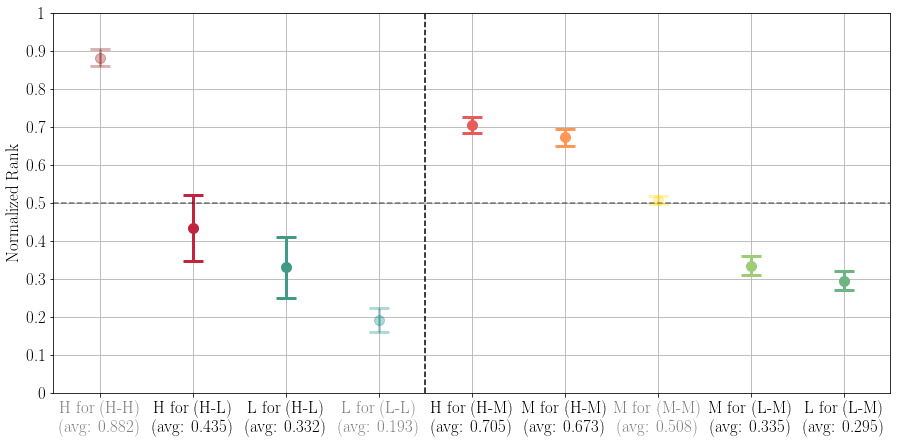

In [18]:
plt.figure(figsize=(15, 7))
plt.grid()

plt.rc('font', family='serif')
plt.rc('font', size=17)

ax = plt.subplot(111)

vals = [0, 3, 6]

avg = np.array(ranks_lta['avg'])
low = np.array(ranks_lta['low'])
high = np.array(ranks_lta['high'])

text_ticks = []
for i in range(len(avg)):
    
    if i in vals:
        alpha = 0.3
    else:
        alpha = 1
    
    plt.errorbar(i, avg[i], yerr=[[high[i]-avg[i]], [avg[i]-low[i]]], 
                fmt='o', markersize=10, capsize=10, capthick=3, lw=3,
                 c=colors[classes_names[i]], alpha=alpha)
    
    text_ticks.append(classes_names[i] + '\n(avg: {:.3f})'.format(avg[i]))

plt.plot([3.5, 3.5], [0, 1], 'k--')
plt.ylim([0, 1])
plt.xlim([-0.5, len(text_ticks)-0.5])
plt.xticks(list(range(len(text_ticks))), text_ticks)

plt.plot([-0.5, len(text_ticks)-0.5], [0.5, 0.5], '--k', alpha=0.5)

yticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

plt.yticks(yticks, yticks)

i=0
for xtick in ax.xaxis.get_ticklabels():

    if i in vals:
        xtick.set(color='gray')

    i+=1
    
plt.ylabel('Normalized Rank')
    
#plt.savefig('../figures/blog/lta_herding_{}.png'.format(min_nbr_ratings), bbox_inches='tight', transparent=True)